In [1]:
# Respect & reference https://github.com/aidiary/pytorch-examples/blob/master/180306-cyclegan-horse2zebra.ipynb
# Respect & reference https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

import os
import random
import itertools
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

from tqdm import tqdm
import glob

%matplotlib inline
print(torch.__version__)

0.4.0


In [2]:
# hyperparameters
load_size = 286  # オリジナルの画像はこのサイズにリサイズ
fine_size = 256  # 286x286の画像からランダムに256x256をcrop
batch_size = 1
num_epoch = 2000

lr = 0.001  # initial learning rate for adam
beta1 = 0.5  # momentum term of adam

save_epoch_freq = 5
log_dir = 'logs'

cuda = torch.cuda.is_available()
if cuda:
    print('cuda available!')

cuda available!


In [168]:
class UnalignedDataset(torch.utils.data.Dataset):

    def __init__(self, is_train):
        super(torch.utils.data.Dataset, self).__init__()

        root_dir = os.path.join('data', '0209')
        
        if is_train:
            dir_A = os.path.join(root_dir, 'trainMS')
            dir_B = os.path.join(root_dir, 'trainMA')
        else:
            dir_A = os.path.join(root_dir, 'testMS')
            dir_B = os.path.join(root_dir, 'testMA')

        self.image_paths_A = self._make_dataset(dir_A)
        self.image_paths_B = self._make_dataset(dir_B)

        self.size_A = len(self.image_paths_A)
        self.size_B = len(self.image_paths_B)

        #!!!
        self.transform = self._make_transform(is_train)

    def __getitem__(self, index):
        index_A = index % self.size_A
        path_A = self.image_paths_A[index_A]
        
        # クラスBの画像はランダムに選択
        index_B = random.randint(0, self.size_B - 1)
        path_B = self.image_paths_B[index_B]

        #img_A = Image.open(path_A).convert('RGB')
        #img_B = Image.open(path_B).convert('RGB')
        nimg_A = np.load(path_A)
        nimg_B = np.load(path_B)
        #nimg_A = np.resize(nimg_A, [64,24])
        #nimg_B = np.resize(nimg_B, [64,24])
        #nimg_A = nimg_A.T
        #nimg_B = nimg_B.T
        img_A = torch.from_numpy(nimg_A)
        img_B = torch.from_numpy(nimg_B)
        #img_A = img_A.unsqueeze(0)
        #img_B = img_B.unsqueeze(0)
        
        # データ拡張
        # label data no kotodeha ?
        #A = self.transform(img_A)
        #B = self.transform(img_B)
        #A = A.type(torch.cuda.FloatTensor)
        #B = B.type(torch.cuda.FloatTensor)
        A = img_A.type(torch.cuda.FloatTensor)
        B = img_B.type(torch.cuda.FloatTensor)
        
        
        return {'A': A, 'B': B, 'path_A': path_A, 'path_B': path_B}
    
    def __len__(self):
        return max(self.size_A, self.size_B)

    def _make_dataset(self, dir):
        images = []
        for fname in os.listdir(dir):
            #if fname.endswith('.jpg'):
            if fname.endswith('.npy'):
                path = os.path.join(dir, fname)
                images.append(path)
        sorted(images)
        return images

    def _make_transform(self, is_train):
        transforms_list = []
        #!!!
        #transforms_list.append(transforms.Resize((load_size, load_size), Image.BICUBIC))
        #transforms_list.append(transforms.RandomCrop(fine_size))
        #if is_train:
            #transforms_list.append(transforms.RandomHorizontalFlip())
        #transforms_list.append(transforms.ToTensor())
        #transforms_list.append(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))  # [0, 1] => [-1, 1]
        return transforms.Compose(transforms_list)

In [169]:
#trainJ = np.load("data/sad2joy/OGVC_JOY/trainJOY.npy")
#file_list1 = sorted(glob.glob("data/Voiceactor/tmpAA/*.npy"))
#x1_train = []
#for i in tqdm(file_list1[:30]):
#    x1_train.append(np.load(i))
#x1_train = np.vstack(x1_train)
#x1_train = np.log10(x1_train)/10.
#trainJ = np.load("data/Voiceactor/tmpAA/")
#trainS = np.load("data/sad2joy/OGVC_SAD/trainSAD.npy")
#testJ = np.load("data/sad2joy/OGVC_JOY/testJOY.npy")
#testS = np.load("data/sad2joy/OGVC_SAD/testSAD.npy")

train_dataset = UnalignedDataset(is_train=True)
#train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x1_train))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=0)

In [170]:
# SAMPLE TEST
batch = iter(train_loader).next()
#print(batch)
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

torch.Size([1, 7, 128, 24])
torch.Size([1, 7, 128, 24])
['data/0209/trainMS/MTY0603SAD3_0.npy']
['data/0209/trainMA/MOY0903ANG1_2.npy']


In [171]:
# データの描画
def imshow(img):
    npimg = img.cpu().numpy()
    npimg = 0.5 * (npimg + 1)  # [-1,1] => [0, 1]
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

TypeError: Invalid dimensions for image data

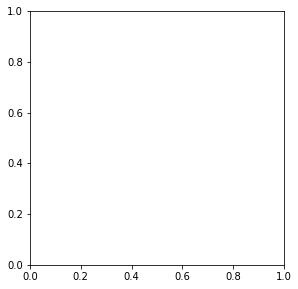

In [172]:

batch = iter(train_loader).next()
images_A = batch['A']  # horses
images_B = batch['B']  # zebras

plt.figure(figsize=(10, 20))

plt.subplot(1, 2, 1)
imshow(make_grid(images_A, nrow=4))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(images_B, nrow=4))
plt.axis('off')


In [173]:
class ResNetBlock(nn.Module):

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim*4, kernel_size=3),
                       nn.InstanceNorm2d(dim*4),
                       nn.GLU(1),
                       #nn.Sigmoid(),
                       nn.ReflectionPad2d(1),
                       nn.Conv2d(dim*2, dim, kernel_size=3),
                       nn.InstanceNorm2d(dim)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [174]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        self.model1 = nn.Sequential(
            nn.ReflectionPad2d(3),

            nn.Conv2d(7, 64, kernel_size=(7,4)),
            nn.InstanceNorm2d(64),
            nn.GLU(1),
            #nn.Sigmoid(),

            nn.Conv2d(32, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.GLU(1),
            #nn.Sigmoid(),

            nn.Conv2d(64, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.GLU(1),
            #nn.Sigmoid(),
        )
        
        self.model2 = nn.Sequential(
            ResNetBlock(128),
            ResNetBlock(128),
            ResNetBlock(128),
            ResNetBlock(128),
            ResNetBlock(128),
            ResNetBlock(128),
            #ResNetBlock(256),
            #ResNetBlock(256),
            #ResNetBlock(256),
        )
        
        self.model3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3,2), stride=2, padding=1, output_padding=(1,0)),
            nn.InstanceNorm2d(64),
            nn.GLU(1),
            #nn.Sigmoid(),

            nn.ConvTranspose2d(32, 16, kernel_size=(3,2), stride=2, padding=1, output_padding=(1,0)),
            nn.InstanceNorm2d(16),
            nn.GLU(1),
            #nn.Sigmoid(),
            
            #nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            #nn.InstanceNorm2d(4),
            #nn.GLU(1),

            #nn.ConvTranspose2d(64, 2, kernel_size=7, stride=1, padding=0, output_padding=0),
            #nn.InstanceNorm2d(8),
            #nn.Sigmoid(),
            nn.ReflectionPad2d(3),
            nn.Conv2d(8, 7, kernel_size=(7,5), stride=1, padding=0),
            nn.Sigmoid()
        )
        
        # initialize weights
        self.model1.apply(self._init_weights)
        self.model2.apply(self._init_weights)
        self.model3.apply(self._init_weights)

    def forward(self, input):
        x = self.model1(input.cuda())
        y = self.model2(x)
        return self.model3(y)

    def _init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal(m.weight.data, 0.0, 0.02)

In [175]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(7, 64, kernel_size=(4,2), stride=1, padding=1),
            nn.GLU(1),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, True),
            nn.Conv2d(32, 128, kernel_size=(4,2), stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.GLU(1),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 256, kernel_size=(4,2), stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.GLU(1),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, True),
            nn.Conv2d(128, 512, kernel_size=(4,2), stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.GLU(1),
            #nn.Sigmoid(),
            #nn.LeakyReLU(0.2, True),
            nn.Conv2d(256, 1, kernel_size=(4,2), stride=1, padding=1),
            nn.Sigmoid()
        )

        # initialize weights
        self.model.apply(self._init_weights)

    def forward(self, input):
        return self.model(input.cuda())

    def _init_weights(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal(m.weight.data, 0.0, 0.02)

In [176]:
def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

gen = Generator()
print_network(gen)

disc = Discriminator()
print_network(disc)

Generator(
  (model1): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(7, 64, kernel_size=(7, 4), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): GLU(dim=1)
    (4): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): GLU(dim=1)
    (7): Conv2d(64, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): GLU(dim=1)
  )
  (model2): Sequential(
    (0): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): GLU(dim=1)
        (4): ReflectionPad2d((1, 1, 1, 1))
        (5): Con

/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:73: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [177]:
class ImagePool():

    def __init__(self, pool_size):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        # プールを使わないときはそのまま返す
        if self.pool_size == 0:
            return Variable(images)
        return_images = []
        for image in images:
            # バッチの次元を削除して3Dテンソルに
            image = torch.unsqueeze(image, 0)
            if self.num_imgs < self.pool_size:
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    random_id = random.randint(0, self.pool_size - 1)
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:
                    return_images.append(image)
        return_images = Variable(torch.cat(return_images, 0))
        return return_images

In [178]:
class GANLoss(nn.Module):
    
    def __init__(self):
        super(GANLoss, self).__init__()
        self.real_label_var = None
        self.fake_label_var = None
        self.loss = nn.MSELoss()
    
    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            # 高速化のため？
            # varがNoneのままか形状が違うときに作り直す
            create_label = ((self.real_label_var is None) or (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = torch.ones(input.size())
                if cuda:
                    real_tensor = real_tensor.cuda()
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = torch.zeros(input.size())
                if cuda:
                    fake_tensor = fake_tensor.cuda()
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)

In [179]:
class CycleGAN(object):
    
    def __init__(self, log_dir='logs'):
        self.netG_A = Generator()
        self.netG_B = Generator()
        self.netD_A = Discriminator()
        self.netD_B = Discriminator()

        if cuda:
            self.netG_A.cuda()
            self.netG_B.cuda()
            self.netD_A.cuda()
            self.netD_B.cuda()

        self.fake_A_pool = ImagePool(50)
        self.fake_B_pool = ImagePool(50)

        # targetが本物か偽物かで代わるのでオリジナルのGANLossクラスを作成
        self.criterionGAN = GANLoss()
        self.criterionCycle = torch.nn.L1Loss()
        self.criterionIdt = torch.nn.L1Loss()

        # Generatorは2つのパラメータを同時に更新
        self.optimizer_G = torch.optim.Adam(
            itertools.chain(self.netG_A.parameters(), self.netG_B.parameters()),
            lr=lr,
            betas=(beta1, 0.999))
        self.optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=lr*0.00001, betas=(beta1, 0.999))
        self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=lr*0.00001, betas=(beta1, 0.999))
        self.optimizers = []
        self.optimizers.append(self.optimizer_G)
        self.optimizers.append(self.optimizer_D_A)
        self.optimizers.append(self.optimizer_D_B)
        
        self.log_dir = log_dir
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
    
    def set_input(self, input):
        input_A = input['A']
        input_B = input['B']
        if cuda:
            input_A = input_A.cuda()
            input_B = input_B.cuda()
        self.input_A = input_A
        self.input_B = input_B
        self.image_paths = input['path_A']

    def backward_G(self, real_A, real_B):
        # Generatorに関連するlossと勾配計算処理
        lambda_idt = 15.0
        lambda_A = 20.0
        lambda_B = 20.0

        # G_A, G_Bは変換先ドメインの本物画像を入力したときはそのまま出力するべき
        # netG_AはドメインAの画像からドメインBの画像を生成するGeneratorだが
        # ドメインBの画像も入れることができる
        # その場合は何も変換してほしくないという制約
        # TODO: idt_Aの命名はよくない気がする idt_Bの方が適切では？
        idt_A = self.netG_A(real_B)
        loss_idt_A = self.criterionIdt(idt_A, real_B) * lambda_B * lambda_idt

        idt_B = self.netG_B(real_A)
        loss_idt_B = self.criterionIdt(idt_B, real_A) * lambda_A * lambda_idt

        # GAN loss D_A(G_A(A))
        # G_Aとしては生成した偽物画像が本物（True）とみなしてほしい
        fake_B = self.netG_A(real_A)
        pred_fake = self.netD_A(fake_B)
        loss_G_A = self.criterionGAN(pred_fake, True)

        # GAN loss D_B(G_B(B))
        # G_Bとしては生成した偽物画像が本物（True）とみなしてほしい
        fake_A = self.netG_B(real_B)
        pred_fake = self.netD_B(fake_A)
        loss_G_B = self.criterionGAN(pred_fake, True)
        
        # forward cycle loss
        # real_A => fake_B => rec_Aが元のreal_Aに近いほどよい
        rec_A = self.netG_B(fake_B)
        loss_cycle_A = self.criterionCycle(rec_A, real_A) * lambda_A
        
        # backward cycle loss
        # real_B => fake_A => rec_Bが元のreal_Bに近いほどよい
        rec_B = self.netG_A(fake_A)
        loss_cycle_B = self.criterionCycle(rec_B, real_B) * lambda_B
        
        # combined loss
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        loss_G.backward()

        # 次のDiscriminatorの更新でfake画像が必要なので一緒に返す
        return loss_G_A.data[0], loss_G_B.data[0], loss_cycle_A.data[0], loss_cycle_B.data[0], loss_idt_A.data[0], loss_idt_B.data[0], fake_A.data, fake_B.data

    def backward_D_A(self, real_B, fake_B):
        # ドメインAから生成したfake_Bが本物か偽物か見分ける

        # TODO: これは何をしている？
        # fake_Bを直接使わずに過去に生成した偽画像から新しくランダムサンプリングしている？
        fake_B = self.fake_B_pool.query(fake_B)

        # 本物画像を入れたときは本物と認識するほうがよい
        pred_real = self.netD_A(real_B)
        loss_D_real = self.criterionGAN(pred_real, True)

        # ドメインAから生成した偽物画像を入れたときは偽物と認識するほうがよい
        # fake_Bを生成したGeneratorまで勾配が伝搬しないようにdetach()する
        pred_fake = self.netD_A(fake_B.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)

        # combined loss
        loss_D_A = (loss_D_real + loss_D_fake) * 0.5
        loss_D_A.backward()
        
        return loss_D_A.data[0]

    def backward_D_B(self, real_A, fake_A):
        # ドメインBから生成したfake_Aが本物か偽物か見分ける

        fake_A = self.fake_A_pool.query(fake_A)
        
        # 本物画像を入れたときは本物と認識するほうがよい
        pred_real = self.netD_B(real_A)
        loss_D_real = self.criterionGAN(pred_real, True)

        # 偽物画像を入れたときは偽物と認識するほうがよい
        pred_fake = self.netD_B(fake_A.detach())
        loss_D_fake = self.criterionGAN(pred_fake, False)
        
        # combined loss
        loss_D_B = (loss_D_real + loss_D_fake) * 0.5
        loss_D_B.backward()
        
        return loss_D_B.data[0]

    def optimize(self):
        real_A = Variable(self.input_A)
        real_B = Variable(self.input_B)
        
        # update Generator (G_A and G_B)
        self.optimizer_G.zero_grad()
        loss_G_A, loss_G_B, loss_cycle_A, loss_cycle_B, loss_idt_A, loss_idt_B, fake_A, fake_B = self.backward_G(real_A, real_B)
        self.optimizer_G.step()

        # update D_A
        self.optimizer_D_A.zero_grad()
        loss_D_A = self.backward_D_A(real_B, fake_B)
        self.optimizer_D_A.step()
        
        # update D_B
        self.optimizer_D_B.zero_grad()
        loss_D_B = self.backward_D_B(real_A, fake_A)
        self.optimizer_D_B.step()

        ret_loss = [loss_G_A, loss_D_A,
                    loss_G_B, loss_D_B,
                    loss_cycle_A, loss_cycle_B,
                    loss_idt_A, loss_idt_B]

        return np.array(ret_loss)

    def train(self, data_loader):
        running_loss = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        for batch_idx, data in enumerate(data_loader):
            self.set_input(data)
            losses = self.optimize()
            running_loss += losses
        running_loss /= len(data_loader)
        return running_loss
    
    def save_network(self, network, network_label, epoch_label):
        save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        save_path = os.path.join(self.log_dir, save_filename)
        # GPUで動いている場合はCPUに移してから保存
        # これやっておけばCPUでモデルをロードしやすくなる?
        #print("Test")
        torch.save(network.cpu().state_dict(), save_path)
        # GPUに戻す
        if torch.cuda.is_available():
            #print("check")
            network.cuda()

    def load_network(self, network, network_label, epoch_label):
        load_filename = '%s_net_%s.pth' % (epoch_label, network_label)
        load_path = os.path.join(self.log_dir, load_filename)
        network.load_state_dict(torch.load(load_path))

    def save(self, label):
        self.save_network(self.netG_A, 'G_A', label)
        self.save_network(self.netD_A, 'D_A', label)
        self.save_network(self.netG_B, 'G_B', label)
        self.save_network(self.netD_B, 'D_B', label)
    
    def load(self, label):
        self.load_network(self.netG_A, 'G_A', label)
        self.load_network(self.netD_A, 'D_A', label)
        self.load_network(self.netG_B, 'G_B', label)
        self.load_network(self.netD_B, 'D_B', label)

In [180]:
# TEST
# netG_AもnetG_Bも同じサイズの画像を生成することが確認できる
model = CycleGAN()
data = iter(train_loader).next()

real_A = Variable(data['A'], volatile=True)
print('real_A:', real_A.size())
fake_B = model.netG_A(real_A)
print('fake_B:', fake_B.size())
recon_A = model.netG_B(fake_B)
print('recon_A:', recon_A.size())

real_B = Variable(data['B'], volatile=True)
print('real_B:', real_B.size())
fake_A = model.netG_B(real_B)
print('fake_A:', fake_A.size())
recon_B = model.netG_A(fake_A)
print('recon_B:', recon_B.size())

# Discriminatorが0 or 1のスカラーを返すのではなく、
# 30x30のfeature mapを返す
# 本物画像のときは30x30がすべて1、偽物画像のときは30x30がすべて0がターゲットとなる
out = model.netD_A(real_A)
print(out.size())

/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:73: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  del sys.path[0]


real_A: torch.Size([1, 7, 128, 24])
fake_B: torch.Size([1, 7, 128, 24])
recon_A: torch.Size([1, 7, 128, 24])
real_B: torch.Size([1, 7, 128, 24])
fake_A: torch.Size([1, 7, 128, 24])
recon_B: torch.Size([1, 7, 128, 24])
torch.Size([1, 1, 14, 5])


In [181]:
criterionGAN = GANLoss()
loss = criterionGAN(out, True)
print(criterionGAN.real_label_var)
loss = criterionGAN(out, False)
print(criterionGAN.fake_label_var)

tensor([[[[ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.]]]], device='cuda:0')
tensor([[[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0

In [ ]:
model = CycleGAN(log_dir)
    
writer = SummaryWriter(log_dir)

for epoch in range(num_epoch):
    losses = model.train(train_loader)

    print('epoch %d, losses: %s' % (epoch + 1, losses))
    writer.add_scalar('loss_G_A', losses[0], epoch)
    writer.add_scalar('loss_D_A', losses[1], epoch)
    writer.add_scalar('loss_G_B', losses[2], epoch)
    writer.add_scalar('loss_D_B', losses[3], epoch)
    writer.add_scalar('loss_cycle_A', losses[4], epoch)
    writer.add_scalar('loss_cycle_B', losses[5], epoch)
    writer.add_scalar('loss_idt_A', losses[6], epoch)
    writer.add_scalar('loss_idt_B', losses[7], epoch)
    
    if epoch % save_epoch_freq == 0:
        model.save('epoch%d' % epoch)

/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:73: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:93: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:115: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launch

epoch 1, losses: [ 0.2474733   0.26044234  0.24606918  0.26709664  6.20721724  6.19347874
 92.49858287 92.66622981]
epoch 2, losses: [ 0.24103687  0.26496872  0.25176067  0.26247656  5.80884815  6.07892564
 90.61766582 86.50623732]
epoch 3, losses: [ 0.24685029  0.25934022  0.25377121  0.26233094  5.32287735  5.66901448
 83.67070378 75.18591737]
epoch 4, losses: [ 0.24718972  0.25765956  0.2469383   0.26671529  4.64254418  5.01482322
 70.89411057 63.18847738]
epoch 5, losses: [ 0.245482    0.25878361  0.24850714  0.26642983  4.34049658  4.57428235
 63.1519428  56.20187762]
epoch 6, losses: [ 0.24955392  0.25776343  0.25004022  0.26549658  4.07856377  4.13481169
 59.29033878 55.09061895]
epoch 7, losses: [ 0.24807289  0.25814363  0.25075433  0.26438813  3.89971735  3.95514353
 57.67635843 53.18335561]
epoch 8, losses: [ 0.25026635  0.25623007  0.25208299  0.26421963  3.68365144  4.47537129
 53.58497389 53.04169407]
epoch 9, losses: [ 0.25110122  0.25596518  0.25398111  0.26274506  3.763

epoch 72, losses: [ 0.30970096  0.21425583  0.28495494  0.23409324  3.03048677  3.06737476
 43.17536698 43.52823415]
epoch 73, losses: [ 0.31306534  0.21413129  0.28485356  0.23418577  3.14176776  3.10772683
 43.82006872 43.46046828]
epoch 74, losses: [ 0.3131392   0.2124958   0.28379017  0.23388034  2.96631384  3.00465447
 40.62126559 42.55081527]
epoch 75, losses: [ 0.31361453  0.21347165  0.27859005  0.23663237  3.07049055  3.18507424
 40.70916828 41.54434998]
epoch 76, losses: [ 0.30888666  0.21398298  0.27664247  0.23690781  3.15271483  3.00980948
 39.51929592 42.60902947]
epoch 77, losses: [ 0.30502521  0.21531366  0.27322162  0.24010453  3.09725085  3.08531493
 41.18519121 40.14822191]
epoch 78, losses: [ 0.30990125  0.21380613  0.27628405  0.23742043  2.9170387   3.04198514
 38.8307671  40.78593149]
epoch 79, losses: [ 0.31673083  0.21143985  0.27391413  0.23883051  3.02283078  3.19673738
 39.55407426 40.17730065]
epoch 80, losses: [ 0.31003652  0.21323286  0.27303273  0.239006

epoch 142, losses: [ 0.25709952  0.2307849   0.28291057  0.22553932  2.0921051   1.21898775
 17.22982599 31.0615606 ]
epoch 143, losses: [ 0.25793322  0.23020062  0.2839899   0.22381046  2.0735553   1.30678739
 18.0467854  31.03637465]
epoch 144, losses: [ 0.25721881  0.23123678  0.28680836  0.2232904   2.11540682  1.39830176
 19.00828768 31.06103902]
epoch 145, losses: [ 0.26128373  0.22854785  0.28498985  0.22369818  2.16760971  1.40309865
 17.93784738 31.14245724]
epoch 146, losses: [ 0.26070183  0.23074835  0.28439101  0.22396685  2.1573363   1.43650083
 19.44852229 31.0409643 ]
epoch 147, losses: [ 0.26190149  0.22847522  0.27928669  0.22578762  2.30868598  1.62317848
 18.11000571 32.73197447]
epoch 148, losses: [ 0.26302561  0.22649838  0.27943431  0.22535689  2.34609138  1.60548239
 20.05891943 32.03880601]
epoch 149, losses: [ 0.2626281   0.22834699  0.28033651  0.22546508  2.2219703   1.28264993
 17.3316468  32.01912249]
epoch 150, losses: [ 0.26060155  0.22879335  0.27801945 

epoch 212, losses: [ 0.27358688  0.22134049  0.25697448  0.23069488  1.37205114  1.03503976
 14.25509429 17.5594961 ]
epoch 213, losses: [ 0.26925001  0.22275992  0.25554195  0.2302985   1.21883199  1.02713868
 14.88783189 17.37299063]
epoch 214, losses: [ 0.26964947  0.22240099  0.25456234  0.23214046  1.12792987  1.06882982
 15.5836714  16.82671299]
epoch 215, losses: [ 0.26859439  0.22163513  0.25070311  0.23300168  1.16154869  1.24080157
 18.11996616 16.81172335]
epoch 216, losses: [ 0.26762561  0.22256789  0.25391782  0.23242512  1.32217838  1.15562916
 15.29859026 19.1491739 ]
epoch 217, losses: [ 0.27142718  0.22234538  0.26118443  0.2286411   1.50447709  1.48213333
 18.76679998 18.53799404]
epoch 218, losses: [ 0.28545028  0.21506275  0.25978443  0.2285463   1.31207797  1.42155831
 19.5795909  17.79800662]
epoch 219, losses: [ 0.27481478  0.2193303   0.25546031  0.23153795  1.23545573  1.3028917
 17.01762288 17.00273764]
epoch 220, losses: [ 0.28267011  0.21551408  0.24915397  

epoch 282, losses: [ 0.29303502  0.21190709  0.25681675  0.23023118  1.34326236  1.4058092
 18.29791611 17.18407949]
epoch 283, losses: [ 0.28813929  0.21396176  0.25169289  0.23030576  1.34071957  1.21631368
 16.39421234 16.35949754]
epoch 284, losses: [ 0.282396    0.21421704  0.25362872  0.22996045  1.12613728  1.21551603
 16.95621589 15.88444729]
epoch 285, losses: [ 0.28250615  0.2163609   0.252202    0.23032946  1.06704543  1.07935664
 15.44835017 15.589198  ]
epoch 286, losses: [ 0.28123126  0.21510868  0.25509398  0.2301581   1.04896217  1.10631644
 15.12032112 15.62029262]
epoch 287, losses: [ 0.28041196  0.21661616  0.25149562  0.22994153  1.0423878   1.16552672
 16.85290689 15.55653779]
epoch 288, losses: [ 0.28297929  0.2138246   0.24283696  0.23477299  1.08168311  1.31712444
 18.80654874 15.6107837 ]
epoch 289, losses: [ 0.29605013  0.2111644   0.25350666  0.23145043  1.11549936  1.48686538
 16.79415328 16.14667426]
epoch 290, losses: [ 0.28806167  0.21102255  0.25691331  

epoch 352, losses: [ 0.28962337  0.21355586  0.25200208  0.23017495  1.01445469  1.14403975
 16.80871198 15.21760862]
epoch 353, losses: [ 0.28695849  0.21286163  0.25221937  0.23116868  1.01373837  1.04560987
 15.33576002 15.2080267 ]
epoch 354, losses: [ 0.28494653  0.21498707  0.24923121  0.23144425  1.01261629  1.08641003
 15.95969647 15.19800974]
epoch 355, losses: [ 0.28387421  0.21584094  0.24404674  0.23375535  1.01165475  1.12255532
 16.49689396 15.18727743]
epoch 356, losses: [ 0.28260402  0.21731543  0.24141617  0.23494647  1.01075902  0.99456203
 14.5850484  15.17718817]
epoch 357, losses: [ 0.28132156  0.21472409  0.24358493  0.23473892  1.00976817  1.11984802
 16.46466607 15.16545887]
epoch 358, losses: [ 0.28041356  0.2158265   0.24110981  0.23576057  1.00893767  1.09655964
 16.12294981 15.15567584]
epoch 359, losses: [ 0.2891098   0.21312936  0.24952856  0.23311798  1.4209702   1.5470299
 18.63197471 18.90117993]
epoch 360, losses: [ 0.30050053  0.20719403  0.26207042  

epoch 422, losses: [ 0.29508806  0.21219754  0.25208345  0.23085994  0.99668121  1.1000583
 16.18606628 14.75673636]
epoch 423, losses: [ 0.29414732  0.2133365   0.25317299  0.23000059  0.99677799  1.07912106
 15.42629611 14.76292098]
epoch 424, losses: [ 0.29326602  0.21071523  0.25817318  0.22905714  1.12955828  1.08171133
 15.91563591 14.88019859]
epoch 425, losses: [ 0.31956808  0.19925644  0.27741434  0.22021041  1.73419455  2.03671081
 20.7119244  18.53261441]
epoch 426, losses: [ 0.31594271  0.20349603  0.27323578  0.22172466  1.13889032  1.36384068
 18.03323132 15.40213484]
epoch 427, losses: [ 0.30623677  0.20715378  0.27490559  0.22065003  1.04366899  1.1813901
 16.2804866  15.4859958 ]
epoch 428, losses: [ 0.30558749  0.20436846  0.27440505  0.221288    1.00734524  1.19589985
 17.16224415 14.89341111]
epoch 429, losses: [ 0.30411344  0.21027053  0.27492145  0.22018957  1.0024874   0.97919883
 14.21417713 14.83688836]
epoch 430, losses: [ 0.30111593  0.20874751  0.27016279  0

epoch 492, losses: [ 0.29980023  0.21047026  0.25982055  0.22655427  0.98739859  1.07553556
 15.70253828 14.63312005]
epoch 493, losses: [ 0.31842184  0.20804952  0.27754601  0.22159219  1.19195208  1.53233018
 15.88250188 16.01862839]
epoch 494, losses: [ 0.31740934  0.20549918  0.28622953  0.2171919   1.18228954  1.23391446
 16.28153459 15.69696064]
epoch 495, losses: [ 0.31412487  0.21090769  0.27638034  0.21927623  1.00710221  0.99809383
 14.52395073 14.80050177]
epoch 496, losses: [ 0.31615691  0.20320357  0.27529921  0.22072175  1.10149996  1.11227643
 15.93857817 14.74823438]
epoch 497, losses: [ 0.32021545  0.20120777  0.27731019  0.21975131  1.00417639  1.11944308
 16.25121592 14.72869951]
epoch 498, losses: [ 0.31334586  0.20095625  0.27326484  0.22126643  1.02831604  1.19752476
 17.52481898 14.67087266]
epoch 499, losses: [ 0.31032462  0.21005071  0.27156131  0.22248619  0.99674587  1.03518425
 15.20127709 14.65082383]
epoch 500, losses: [ 0.30611076  0.20654538  0.26806876 

epoch 562, losses: [ 0.30334474  0.20644011  0.26596879  0.22528915  0.98653371  1.111953
 16.35712187 14.54989016]
epoch 563, losses: [ 0.31917022  0.21104347  0.27725823  0.2203207   1.11767533  1.38837903
 15.74734914 15.16943342]
epoch 564, losses: [ 0.32139563  0.20209005  0.28509958  0.21692038  1.03709229  1.22490843
 15.91622131 15.08784101]
epoch 565, losses: [ 0.32143506  0.20378012  0.27706625  0.22042578  1.01505032  1.05769252
 15.53765541 14.76464167]
epoch 566, losses: [ 0.32160162  0.20561285  0.27900707  0.2191191   0.98751339  1.03545681
 14.82527319 14.6150042 ]
epoch 567, losses: [ 0.314832    0.20698669  0.2771049   0.21949069  0.99830964  1.12790885
 15.20208138 14.81481283]
epoch 568, losses: [ 0.31355288  0.2071615   0.27346377  0.22162437  0.98347042  1.0170304
 14.90813889 14.5704466 ]
epoch 569, losses: [ 0.31109379  0.20938733  0.27701696  0.21973593  1.43826157  1.20168201
 14.77147298 16.18533876]
epoch 570, losses: [ 0.31715925  0.20589291  0.28279182  0.

epoch 632, losses: [ 0.29167203  0.21460994  0.25254105  0.23179089  0.97060114  1.04464997
 15.40737333 14.40673918]
epoch 633, losses: [ 0.29313562  0.21718355  0.25373951  0.23109459  0.97019796  1.02901929
 15.18152564 14.40022713]
epoch 634, losses: [ 0.29626607  0.2137683   0.25702227  0.23050614  1.15948432  1.08699575
 15.69319851 15.66212442]
epoch 635, losses: [ 0.33404965  0.19896805  0.28798453  0.21753735  1.9682452   1.78331978
 19.18623701 17.61050687]
epoch 636, losses: [ 0.33459424  0.2017902   0.28344167  0.21701919  1.07022406  1.13922781
 15.71046509 14.96730754]
epoch 637, losses: [ 0.3282184   0.19963071  0.28524674  0.21791128  1.00036808  1.14694296
 16.73611932 14.56862948]
epoch 638, losses: [ 0.32171384  0.20568784  0.27564765  0.22116499  0.98058712  1.02656568
 15.09777076 14.47741936]
epoch 639, losses: [ 0.3158369   0.21339533  0.27289031  0.22187259  0.97712659  0.91822526
 13.48244966 14.45430707]
epoch 640, losses: [ 0.3101931   0.2119081   0.27268535 

epoch 702, losses: [ 0.31278704  0.20797967  0.28254872  0.21833399  0.97684358  1.08907082
 15.70062996 14.47534877]
epoch 703, losses: [ 0.30807236  0.20841382  0.27945423  0.21912758  0.97079223  1.03667715
 15.24740899 14.40047594]
epoch 704, losses: [ 0.3037874   0.21159094  0.27453789  0.22161041  0.96882873  1.04890348
 15.46199188 14.3754604 ]
epoch 705, losses: [ 0.3003813   0.21523549  0.27051305  0.22265152  0.96750121  0.97070298
 14.29302679 14.35752083]
epoch 706, losses: [ 0.2967655   0.21426437  0.2659147   0.22477658  0.96643659  1.00370344
 14.79174261 14.3436737 ]
epoch 707, losses: [ 0.29347678  0.21605126  0.26431898  0.22581064  0.96548726  1.01697869
 15.00296586 14.33149616]
epoch 708, losses: [ 0.29068205  0.21699363  0.26114416  0.22684043  0.96482774  1.10608942
 16.34346221 14.32320711]
epoch 709, losses: [ 0.28779932  0.21635054  0.25928953  0.22830577  0.96430007  1.11244198
 16.44251697 14.31673951]
epoch 710, losses: [ 0.28570579  0.21920927  0.26057769 

epoch 772, losses: [ 0.29215983  0.21655183  0.26190375  0.22701014  0.96121661  0.97154508
 14.31653837 14.24771928]
epoch 773, losses: [ 0.28982479  0.21604815  0.26030366  0.22861863  0.96079088  1.06082989
 15.6589972  14.24218925]
epoch 774, losses: [ 0.28779075  0.21869219  0.26132854  0.22853219  0.9603325   0.98725891
 14.55528896 14.23853325]
epoch 775, losses: [ 0.28556701  0.21670582  0.26135043  0.22725872  0.9599078   1.08850541
 16.07675942 14.234308  ]
epoch 776, losses: [ 0.28315402  0.21974061  0.26087117  0.22878051  0.95961128  1.06107641
 15.66343309 14.23195854]
epoch 777, losses: [ 0.2951478   0.21690824  0.26347432  0.2282123   1.12111006  1.41393506
 16.73912119 15.5423497 ]
epoch 778, losses: [ 0.33375784  0.19838237  0.30236611  0.21171376  1.53990924  1.61835006
 18.19785184 17.4090548 ]
epoch 779, losses: [ 0.32384083  0.20768799  0.29671829  0.21338607  1.09387357  1.16597978
 14.31704751 15.22691961]
epoch 780, losses: [ 0.32438782  0.20552169  0.29481897 

epoch 842, losses: [ 0.23398056  0.2517536   0.29776353  0.21141306  1.02025002  0.29540675
  1.44622655 14.77278807]
epoch 843, losses: [ 0.23292289  0.25038301  0.29574471  0.21203478  0.98652705  0.1636023
  1.10853962 14.59701756]
epoch 844, losses: [ 0.22867463  0.25718396  0.28927005  0.21390493  0.98349509  0.11512557
  1.09239687 14.44574548]
epoch 845, losses: [ 0.2187835   0.26113142  0.28476168  0.21638026  0.97283378  0.09581134
  1.05222542 14.38415457]
epoch 846, losses: [ 0.20870438  0.27264004  0.28539301  0.21580098  0.97041543  0.09421356
  1.0543973  14.35204265]
epoch 847, losses: [ 0.20021068  0.27551223  0.28490254  0.2158964   0.9687952   0.09115529
  1.02670308 14.32998275]
epoch 848, losses: [ 0.19484174  0.28052457  0.28007753  0.21787992  0.9677515   0.09063122
  1.02389329 14.31373199]
epoch 849, losses: [ 0.18893383  0.28861673  0.2794343   0.21811251  0.96685785  0.08904104
  1.01801909 14.30033411]
epoch 850, losses: [ 0.18390097  0.28559569  0.27829332  

epoch 912, losses: [ 0.19513349  0.27159364  0.29061853  0.21395097  0.97067751  0.0934735
  1.01634538 14.33761093]
epoch 913, losses: [ 0.18930496  0.27740046  0.28535592  0.21608006  0.96749725  0.08986832
  0.98630723 14.30254647]
epoch 914, losses: [ 0.1850562   0.28137131  0.28342998  0.21707359  0.9652739   0.08792089
  0.96889179 14.27822772]
epoch 915, losses: [ 0.18068793  0.28163647  0.28336817  0.21772682  0.96363391  0.08648647
  0.95949649 14.2600707 ]
epoch 916, losses: [ 0.17785795  0.28459878  0.28217679  0.21821919  0.96257052  0.08529299
  0.94827271 14.24731601]
epoch 917, losses: [ 0.1749021   0.28902674  0.28095447  0.21785956  0.96177541  0.08322411
  0.92410225 14.2382298 ]
epoch 918, losses: [ 0.17379177  0.29126243  0.27759559  0.21970795  0.9610367   0.08300483
  0.91802332 14.22954221]
epoch 919, losses: [ 0.17277278  0.28721543  0.28036316  0.21908268  0.96056471  0.08439551
  0.94206033 14.22214903]
epoch 920, losses: [ 0.17191011  0.28805812  0.27727645  

epoch 982, losses: [ 0.25895503  0.23917125  0.30162223  0.21151318  0.99945109  0.12980768
  1.22178397 14.40199431]
epoch 983, losses: [ 0.25576148  0.2408407   0.29872391  0.21257267  0.96971559  0.09156533
  0.91954056 14.29537729]
epoch 984, losses: [ 0.24810953  0.24356966  0.29600622  0.21378922  0.96612238  0.08842134
  0.90244711 14.25987628]
epoch 985, losses: [ 0.24406862  0.24720432  0.28977613  0.21608915  0.96383408  0.08511312
  0.87752136 14.23773621]


In [ ]:
##### test_dataset = UnalignedDataset(is_train=False)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)

In [18]:
batch = iter(test_loader).next()
print(batch['A'].shape)
print(batch['B'].shape)
print(batch['path_A'])
print(batch['path_B'])

torch.Size([1, 4, 128, 24])
torch.Size([1, 4, 128, 24])
['data/0903/testFOJ/FOY0402JOY3_6.npy']
['data/0903/testFOA/FOY0111ANG3_4.npy']


In [19]:
#imshow(make_grid(batch['A'], nrow=2))
#plt.axis('off')
print("test")

test


In [18]:
model = CycleGAN()
model.log_dir = 'SJnim/' 
model.load('epoch1995')

/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:73: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/yasuda/.pyenv/versions/anaconda3-4.3.1/envs/pytorch3/lib/python3.5/site-packages/ipykernel_launcher.py:39: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


In [19]:
filenames = os.listdir("/home/yasuda/03_MANA/CycleGAN-Q/data/0114/testFS")
num_files = len(filenames)
filename = []
output = []
for i in filenames:
    fileload = np.load("/home/yasuda/03_MANA/CycleGAN-Q/data/0114/testFS/"+i)
    img_torch = torch.from_numpy(fileload)
    img_torch = img_torch.unsqueeze(0)
    #img_torch = img_torch.unsqueeze(0)
    filetorch = img_torch.type(torch.cuda.FloatTensor)
    #print(filetorch.shape)
    fake_A = model.netG_B(filetorch)
    #fake_img = model.netG_B(filetorch)
    out = fake_A.cpu().detach().numpy()
    out = np.resize(out, [7, 128, 24])
    #print(out.shape)
    np.save("/home/yasuda/03_MANA/CycleGAN-Q/data/0114/convFZJ2S/"+i, out)

In [20]:
filenames = os.listdir("/home/yasuda/03_MANA/CycleGAN-Q/data/0114/testFS")
num_files = len(filenames)
filename = []
output = []
for i in filenames:
    fileload = np.load("/home/yasuda/03_MANA/CycleGAN-Q/data/0114/testFS/"+i)
    img_torch = torch.from_numpy(fileload)
    img_torch = img_torch.unsqueeze(0)
    #img_torch = img_torch.unsqueeze(0)
    filetorch = img_torch.type(torch.cuda.FloatTensor)
    #print(filetorch.shape)
    fake_A = model.netG_B(filetorch)
    #fake_img = model.netG_B(filetorch)
    out = fake_A.cpu().detach().numpy()
    out = np.resize(out, [7, 128, 24])
    #print(out.shape)
    np.save("/home/yasuda/03_MANA/CycleGAN-Q/data/0114/convFZS2J/"+i, out)

In [21]:
filenames = os.listdir("/home/yasuda/03_MANA/CycleGAN-Q/data/1026/testMA")
num_files = len(filenames)
filename = []
output = []
for i in filenames:
    fileload = np.load("/home/yasuda/03_MANA/CycleGAN-Q/data/1026/testMA/"+i)
    img_torch = torch.from_numpy(fileload)
    img_torch = img_torch.unsqueeze(0)
    #img_torch = img_torch.unsqueeze(0)
    filetorch = img_torch.type(torch.cuda.FloatTensor)
    #print(filetorch.shape)
    fake_A = model.netG_B(filetorch)
    #fake_img = model.netG_B(filetorch)
    out = fake_A.cpu().detach().numpy()
    out = np.resize(out, [7, 128, 24])
    #print(out.shape)
    np.save("/home/yasuda/03_MANA/CycleGAN-Q/data/1026/convMZA2J/"+i, out)

FileNotFoundError: [Errno 2] No such file or directory: 'data/0514/output_fake_A_H/[].npy'

(-0.5, 23.5, 127.5, -0.5)

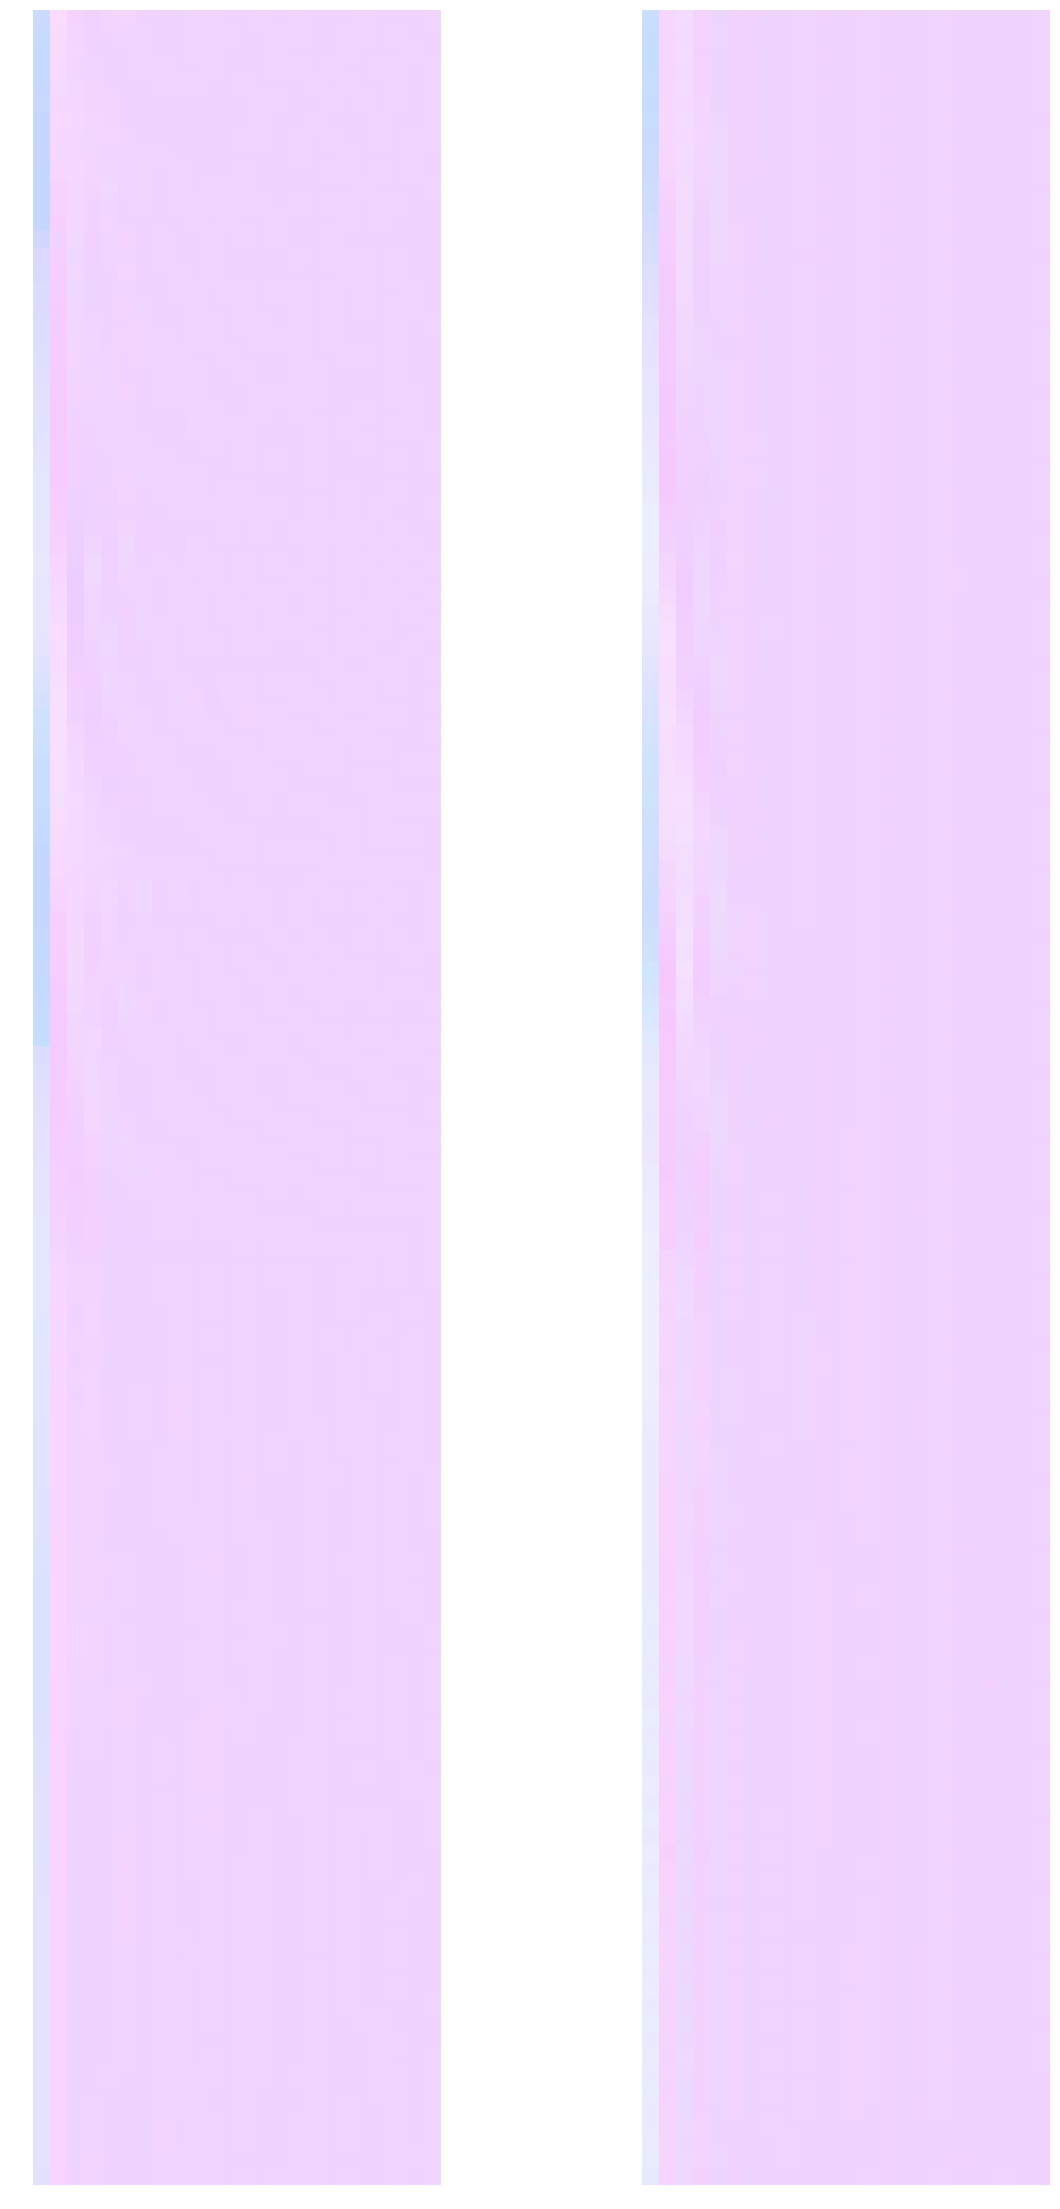

In [22]:
plt.figure(figsize=(20, 40))

plt.subplot(1, 2, 1)
imshow(make_grid(batch['B'], nrow=2))
plt.axis('off')

plt.subplot(1, 2, 2)
imshow(make_grid(fake_A.data, nrow=2))
plt.axis('off')

In [23]:
tensorboard --logdir "logs"

SyntaxError: invalid syntax (<ipython-input-23-45290ea7ef63>, line 1)